In [2]:
import numpy as np
import random
import sklearn
from sklearn import metrics, ensemble, preprocessing
from matplotlib import pyplot as plt
from scipy.stats import norm
import os
import datetime

np.set_printoptions(suppress=True)
np.random.seed(100)
random.seed(100)

In [3]:
import tensorflow as tf
from tensorflow import keras

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

print(tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

# tf.compat.v1.disable_eager_execution()
tf.config.run_functions_eagerly(True)

2023-05-01 01:12:17.464949: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1
GPU available: 8


In [4]:
PROJECT_PATH = '/raid/shumnov/music-style-performer/'

In [5]:
NOTES_QTY = 16
NOTE_PARAMS = 3
TEST_LEN = 19000

NOTE_MIN = -24
NOTE_MAX = 24
TIME_MAX = 6000

In [6]:
def prepare(dset):
    res = np.delete(dset, (1, 2), axis=2)
    
    tmp = res[..., 1].copy()
    res[..., 1] = res[..., 2]
    res[..., 2] = tmp
    
    # 0 - note
    # 1 - duration
    # 2 - velocity
    
    return res

In [7]:
def filter_outliers(dset):
    conds = []
    notes = dset[..., 0]
    durs = dset[..., 1]
    for i in range(NOTES_QTY):
        conds.append(notes[..., i] <= NOTE_MAX)
        conds.append(notes[..., i] >= NOTE_MIN)
        conds.append(durs[..., i] < TIME_MAX)
        conds.append(durs[..., i] > 0)
    cond = np.logical_and.reduce(conds)
    
    return dset[cond]
    
def normalize(dset, params=None):
    dset = dset.copy()
    
    dset[..., 1] = np.log(dset[..., 1])
    
    if params is not None:
        note_mean, note_std, dur_mean, dur_std, vel_mean, vel_std = params
    else:
        note_mean = np.mean(dset[..., 0])
        note_std = np.std(dset[..., 0])
    
        dur_mean = np.mean(dset[..., 1])
        dur_std = np.std(dset[..., 1])
    
        vel_mean = np.mean(dset[..., 2])
        vel_std = np.std(dset[..., 2])
    
    dset[..., 0] = (dset[..., 0] - note_mean) / note_std
    dset[..., 1] = (dset[..., 1] - dur_mean) / dur_std
    dset[..., 2] = (dset[..., 2] - vel_mean) / vel_std
    
    if params is not None:
        return dset
    else:
        return dset, (note_mean, note_std, dur_mean, dur_std, vel_mean, vel_std)
    

In [8]:
def mess_n(lines, n):
    mu, std = norm.fit(lines[..., 2].flatten())
    
    for line in lines:
        idxs = random.sample(range(len(line)), n)

        for idx in idxs:
            line[idx][2] = np.random.normal(mu, std)
            
def mess(test):
    test_messed = test.copy()
    for i in range(NOTES_QTY):
        mess_n(test_messed[i * TEST_LEN: (i + 1) * TEST_LEN], i+1)
        
    return test_messed

In [9]:
dset = np.load(PROJECT_PATH + 'data/dset16.npy')
dset = dset.astype(float)

tdset = np.load(PROJECT_PATH + 'data/test_dset16.npy')
tdset = tdset.astype(float)

In [10]:
dset = prepare(dset)
tdset = prepare(tdset)

# np.random.seed(100)
# np.random.shuffle(processed)

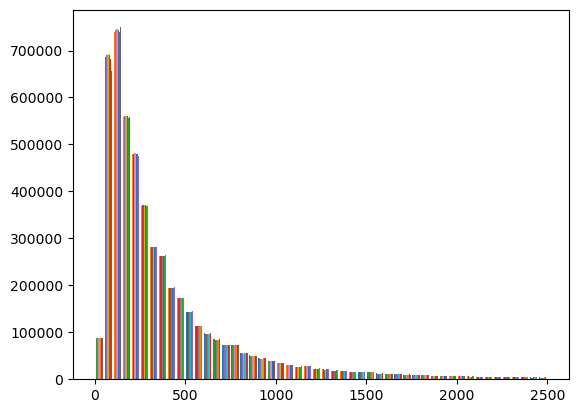

In [14]:
plt.hist(dset[..., 1], bins=50, range=[0, 2500])
plt.show()

In [21]:
train  = filter_outliers(dset)
print(f'{len(dset) - len(train)} train samples filtered. {len(train)} left')

train, params = normalize(train)
print(params)

181795 train samples filtered. 4890216 left
(-0.0006052263335607262, 4.132044170275806, 5.560632707014063, 0.9528834736310532, 70.6449790510276, 15.86987401301365)


In [11]:
test = filter_outliers(tdset)
print(f'{len(tdset) - len(test)} test samples filtered. {len(test)} left')

np.random.seed(100)
np.random.shuffle(test)

test = test[:NOTES_QTY * TEST_LEN]
test_messed = mess(test)

test = normalize(test, params)
test_messed = normalize(test_messed, params)

72412 test samples filtered. 1528766 left


In [12]:
print(f'train: {train.shape}, test: {test.shape}, messed: {test_messed.shape}')

train: (4890216, 16, 3), test: (304000, 16, 3), messed: (304000, 16, 3)


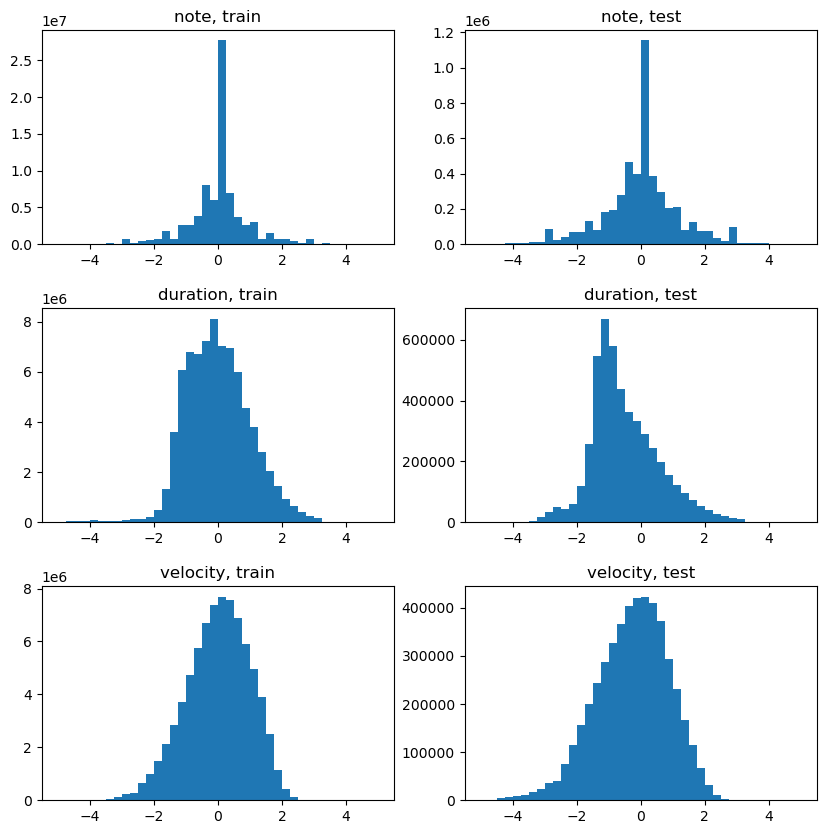

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# note

axs[0][0].title.set_text('note, train')
axs[0][0].hist(train[..., 0].flatten(), bins=40, range=[-5, 5])

axs[0][1].title.set_text('note, test')
axs[0][1].hist(test[..., 0].flatten(), bins=40, range=[-5, 5])

# duration 

axs[1][0].title.set_text('duration, train')
axs[1][0].hist(train[..., 1].flatten(), bins=40, range=[-5, 5])

axs[1][1].title.set_text('duration, test')
axs[1][1].hist(test[..., 1].flatten(), bins=40, range=[-5, 5])

# velocity

axs[2][0].title.set_text('velocity, train')
axs[2][0].hist(train[..., 2].flatten(), bins=40, range=[-5, 5])

axs[2][1].title.set_text('velocity, test')
axs[2][1].hist(test[..., 2].flatten(), bins=40, range=[-5, 5])

plt.subplots_adjust(hspace=0.3)
plt.show()

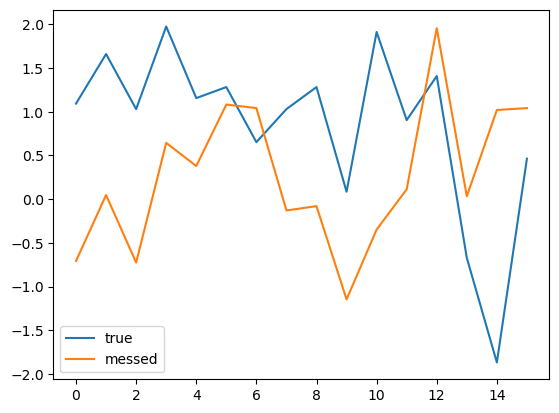

In [14]:
idx = 300000

plt.plot(range(NOTES_QTY), test[idx][..., 2], label='true')
plt.plot(range(NOTES_QTY), test_messed[idx][..., 2], label='messed')

plt.legend()
plt.show()

# Models

In [17]:
LATENT_DIM = 24
I = 0.01 # noise

## Autoencoder

In [18]:
class LstmAutoencoder(keras.Model):
    def __init__(self):
        super(LstmAutoencoder, self).__init__()
        
        self.build_encoder()
        self.build_decoder()
        
    def build_encoder(self):        
        self.encoder = keras.Sequential([
            keras.layers.Input(shape=(NOTES_QTY, NOTE_PARAMS)),
            keras.layers.LSTM(LATENT_DIM, activation="tanh"),
        ])
        
    def build_decoder(self):
        self.decoder = keras.Sequential([
            keras.layers.RepeatVector(NOTES_QTY),
            keras.layers.LSTM(NOTE_PARAMS, return_sequences=True)
        ])

    def call(self, x, training=True):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded


In [22]:
class MultiLayerAutoencoder(keras.Model):
    def __init__(self):
        super(MultiLayerAutoencoder, self).__init__()
        
        self.build_encoder()
        self.build_decoder()
        
    def build_encoder(self):        
        self.encoder = keras.Sequential([
            keras.layers.Flatten(),
            
            keras.layers.Dense(64, activation='relu'), # 48x64 64x64 64x32 32x32
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation='relu'), 
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(32, activation='relu'),
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(LATENT_DIM, activation='tanh'),
        ])
        
    def build_decoder(self):
        self.decoder = keras.Sequential([
            keras.layers.Input(shape=(LATENT_DIM)), # 32x32 32x64 64x64 64x48
            
            keras.layers.Dense(32, activation='relu'),
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation='relu'),
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation='relu'),
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(NOTES_QTY * NOTE_PARAMS, activation='linear'),
            
            keras.layers.Reshape((NOTES_QTY, NOTE_PARAMS))
        ])

    def call(self, x, training=True):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

In [24]:
autoencoder = MultiLayerAutoencoder()

print(train[0:1].shape)
test_out = autoencoder(train[0:1], training=False)
print(test_out.shape)

en_test_out = autoencoder.encoder(train[0:1], training=False)
print(en_test_out.shape)

de_test_out = autoencoder.decoder(en_test_out, training=False)
print(de_test_out.shape)

(1, 16, 3)
(1, 16, 3)
(1, 24)
(1, 16, 3)


In [19]:
autoencoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [20]:
autoencoder.compile(optimizer=autoencoder_optimizer, loss=tf.keras.losses.MeanSquaredError())

## Latent Discriminator

In [21]:
class LatentDisc(keras.Model):
    def __init__(self):
        super(LatentDisc, self).__init__()
        
        # self.l1 = keras.layers.Dense(128, activation='relu')(self.input)
        self.l1 = keras.layers.Dense(64, activation='relu')
        self.l2 = keras.layers.Dense(32, activation='relu')
        self.l3 = keras.layers.Dense(16, activation='relu')
        self.outp = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x, training=True):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.outp(x)
        return x

In [22]:
ldisc = LatentDisc()

test_out = ldisc(np.ones(shape=(1, LATENT_DIM)), training=False)
print(test_out.shape)

(1, 1)


In [23]:
ldisc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

## Visual Discriminator
(and classifier)

In [24]:
class LstmVisualDisc(keras.Model):
    def __init__(self):
        super(LstmVisualDisc, self).__init__()
        
        self.lstm = keras.layers.LSTM(1)
        self.outp = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x, training=True):
        x = self.lstm(x)
        x = self.outp(x)
        return x

In [25]:
class MultiLayerVisualDisc(keras.Model):
    def __init__(self):
        super(MultiLayerVisualDisc, self).__init__()
        
        self.flatten = keras.layers.Flatten()
        self.l1 = keras.layers.Dense(64, activation='relu')
        self.l2 = keras.layers.Dense(32, activation='relu')
        self.l3 = keras.layers.Dense(16, activation='relu')
        self.outp = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x, training=True):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.outp(x)
        return x

In [26]:
vdisc = MultiLayerVisualDisc()

test_out = vdisc(train[0:1], training=False)
print(test_out.shape)

(1, 1)


In [27]:
vdisc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [28]:
classifier = MultiLayerVisualDisc()
test_out = classifier(train[0:1], training=False)
print(test_out.shape)

(1, 1)


In [29]:
classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Helpers

In [30]:
checkpoint_dir = PROJECT_PATH + 'train_data/ocgan_mlp_1/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(autoencoder_optimizer=autoencoder_optimizer,
                                ldisc_optimizer=ldisc_optimizer,
                                vdisc_optimizer=vdisc_optimizer,
                                classifier_optimizer=classifier_optimizer,
                                autoencoder=autoencoder,
                                ldisc=ldisc,
                                vdisc=vdisc,
                                classifier=classifier)

In [31]:
log_dir=PROJECT_PATH + 'train_data/ocgan_mlp_1/logs/'

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                     update_freq='batch')

In [32]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()

In [33]:
l2_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)

# Prediction

In [34]:
from sklearn.metrics import mean_squared_error

In [35]:
# @tf.function
# def mse_pair(x):
#     return mse(x[0], x[1])
# 
# @tf.function
# def predict(x):
#     y = autoencoder(x)
#     
#     stacked = tf.stack([x, y], axis=1)
#     err = tf.map_fn(mse_pair, stacked)
#     
#     return err

In [51]:
@tf.function
def predict(x):
    y = autoencoder(x)
    
    err = tf.math.square(x[..., 2] - y[..., 2])
    # err = tf.math.reduce_mean(err, axis=2)
    err = tf.math.reduce_mean(err, axis=1)
    
    err = tf.math.sqrt(err)
    
    return err

In [52]:
predict(test).numpy()

array([0.5039291 , 0.72275   , 0.64561933, ..., 0.49799532, 0.41067758,
       0.8922011 ], dtype=float32)

# Training

In [64]:
INM_ITERS = 5
LAMBDA = 4
EPOCHS = 10
BATCH_SIZE = 32

In [65]:
train_dataset = tf.data.Dataset.from_tensor_slices(train).batch(BATCH_SIZE)

In [66]:
@tf.function
def train_step(x, step):
    batch_size = x.shape[0]
    zeros = np.zeros((batch_size, 1))
    ones = np.ones((batch_size, 1))
    
    n = np.random.normal(0, I, x.shape)
    x_noisy = x + n
    
    l1 = autoencoder.encoder(x_noisy)
    l2 = tf.Variable(np.random.uniform(-1, 1, (batch_size, LATENT_DIM)))
    
    #
    # Classifier update
    #
    
    with tf.GradientTape() as gt:
        l_classifier = bce(zeros, classifier(autoencoder.decoder(l2))) \
                        + bce(ones, classifier(autoencoder.decoder(l1)))
        
    classifier_gradients = gt.gradient(l_classifier, classifier.trainable_variables)
    classifier_optimizer.apply_gradients(zip(classifier_gradients, classifier.trainable_variables)) 
    
    #
    # Discriminator update
    #
    
    with tf.GradientTape(persistent=True) as gt:
        l_latent = bce(zeros, ldisc(l1)) \
                    + bce(ones, ldisc(l2))
        
        l_visual = bce(zeros, vdisc(autoencoder.decoder(l2))) \
                    + bce(ones, vdisc(x))
        
    ldisc_gradients = gt.gradient(l_latent, ldisc.trainable_variables)
    ldisc_optimizer.apply_gradients(zip(ldisc_gradients, ldisc.trainable_variables))
    
    vdisc_gradients = gt.gradient(l_visual, vdisc.trainable_variables)
    vdisc_optimizer.apply_gradients(zip(vdisc_gradients, vdisc.trainable_variables))
    
    #
    # Informative-negative mining
    #
    
    for i in range(INM_ITERS):
        with tf.GradientTape() as gt:
            l_l2 = bce(ones, classifier(autoencoder.decoder(l2)))
        
        l2_gradients = gt.gradient(l_l2, l2)
        l2_optimizer.apply_gradients([(l2_gradients, l2)])
    
    #
    # Generator update
    #
    
    with tf.GradientTape() as gt:
        gt.watch(autoencoder.variables)
        
        l1 = autoencoder.encoder(x_noisy)
        
        l_ae_latent = bce(ones, ldisc(l1))
        l_ae_visual = bce(ones, vdisc(autoencoder.decoder(l2)))
        l_ae_mse = mse(x, autoencoder(x_noisy))
        
        total_ae_loss = l_ae_latent + l_ae_visual + LAMBDA * l_ae_mse
        
    ae_gradients = gt.gradient(total_ae_loss, autoencoder.variables)
    autoencoder_optimizer.apply_gradients(zip(ae_gradients, autoencoder.variables))
      
    #
    # Logging 
    #
    
    with summary_writer.as_default():
        tf.summary.scalar('l_classifier', l_classifier, step=step)
        tf.summary.scalar('l_latent', l_latent, step=step)
        tf.summary.scalar('l_visual', l_visual, step=step)
        tf.summary.scalar('l_ae_mse', l_ae_mse, step=step)
        tf.summary.scalar('l_ae_latent', l_ae_latent, step=step)
        tf.summary.scalar('l_ae_visual', l_ae_visual, step=step)
        tf.summary.scalar('l_ae_total', total_ae_loss, step=step)
 

In [67]:
# %reload_ext tensorboard
# %tensorboard --logdir {log_dir} --host "0.0.0.0"

In [68]:
checkpoint.restore(checkpoint_dir + '/ckpt-1')

In [69]:
@tf.function
def fit(start, epochs):
    step = 0
    for epoch in range(start, start + epochs):
        for batch in train_dataset:
            train_step(batch, tf.cast(step, tf.int64))
            
            if (step+1) % 1000 == 0:
                print('.', end='', flush=True)
                
            step += 1
                
        checkpoint.save(file_prefix=checkpoint_prefix)

In [70]:
fit(0, 10)

.................................................................................................................................................................

KeyboardInterrupt: 

In [ ]:
for i in range(1, EPOCHS):
    n = np.random.normal(0, I, train.shape)

    autoencoder.fit(x=train+n, y=train, 
                    batch_size=BATCH_SIZE, epochs=i+1, 
                    initial_epoch=i,
                    shuffle=True,
                    callbacks=[tensorboard_callback])
        
    checkpoint.save(file_prefix=checkpoint_prefix)

# Validate

In [77]:
checkpoint.restore(checkpoint_dir + '/ckpt-1')

In [78]:
true_predict = predict(test).numpy()
messed_predict = predict(test_messed).numpy()

groups = [(true_predict[i:i+TEST_LEN], messed_predict[i:i+TEST_LEN]) for i in range(0, len(test), TEST_LEN)]

In [75]:
from tabulate import tabulate

def show(groups):
    x = list(range(1, NOTES_QTY + 1))
    y_mean = []
    y_var = []
    
    diffs = []

    for i in range(NOTES_QTY):
        diff = groups[i][1] - groups[i][0]
        diffs.append(diff)

        m = np.mean(diff)
        var = np.std(diff) / m

        y_mean.append(m)
        y_var.append(var)
        
    idxs = [0, 1, 2, 3, 7, 8, 14, 15]
    print(tabulate([['mean'] + [y_mean[i] for i in idxs], ['var'] + [y_var[i] for i in idxs]], headers=[i + 1 for i in idxs]))

    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    
    axs[0][0].title.set_text('Diff - Average')
    axs[0][0].plot(x, y_mean, 'o-')
    
    axs[0][1].title.set_text('Diff - Coefficient of variation')
    axs[0][1].plot(x, y_var, 'o-')
    
    axs[1][0].title.set_text('Diff 1-2')
    for i in range(0, 2):
        axs[1][0].hist(diffs[i], bins=30, label=str(i + 1), alpha=0.5)
    axs[1][0].legend()
    
    axs[1][1].title.set_text('Diff 3-4')
    for i in range(2, 4):
        axs[1][1].hist(diffs[i], bins=30, label=str(i + 1), alpha=0.5)
    axs[1][1].legend()
    
    axs[2][0].title.set_text('Diff 8-9')
    for i in range(7, 9):
        axs[2][0].hist(diffs[i], bins=30, label=str(i + 1), alpha=0.5)
    axs[2][0].legend()
    
    axs[2][1].title.set_text('Diff 15-16')
    for i in range(14, 16):
        axs[2][1].hist(diffs[i], bins=30, label=str(i + 1), alpha=0.5)
    axs[2][1].legend()
    
    plt.subplots_adjust(hspace=0.3)
    plt.show()

              1         2         3         4         8         9        15        16
----  ---------  --------  --------  --------  --------  --------  --------  --------
mean  0.0670646  0.120148  0.169704  0.211578  0.325644  0.350719  0.407143  0.415974
var   1.87647    1.40521   1.18997   1.06113   0.871406  0.835923  0.830392  0.835478


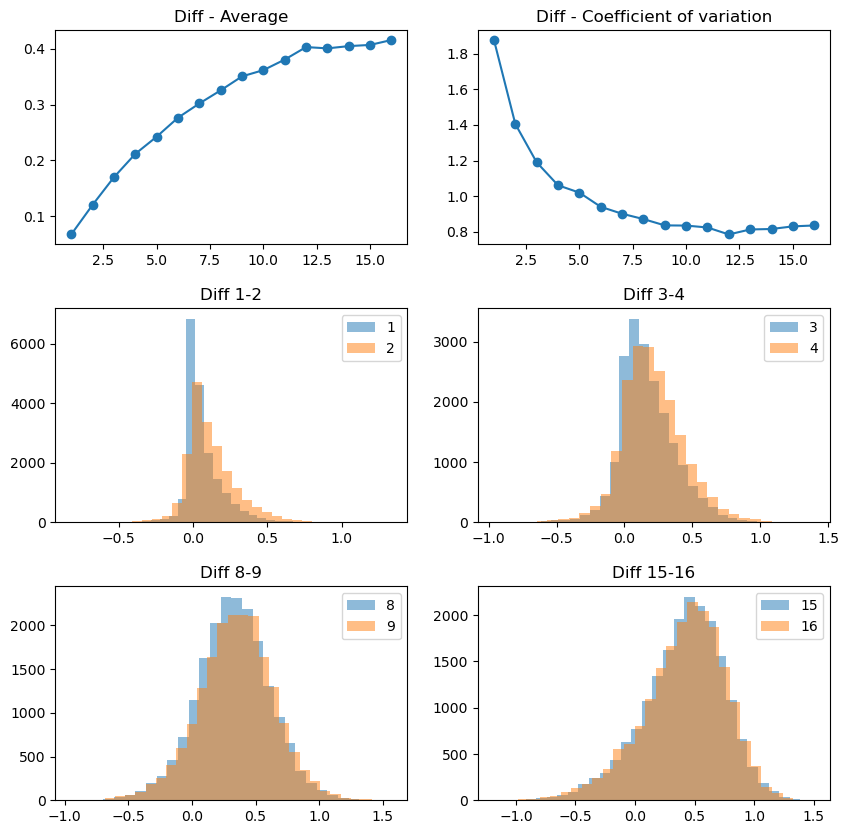

In [79]:
show(groups)

              1          2          3        4         8         9        15        16
----  ---------  ---------  ---------  -------  --------  --------  --------  --------
mean  0.0362156  0.0681421  0.0986231  0.12543  0.204667  0.223908  0.271441  0.276691
var   2.79744    2.08988    1.78863    1.59373  1.3374    1.29343   1.36283   1.40336


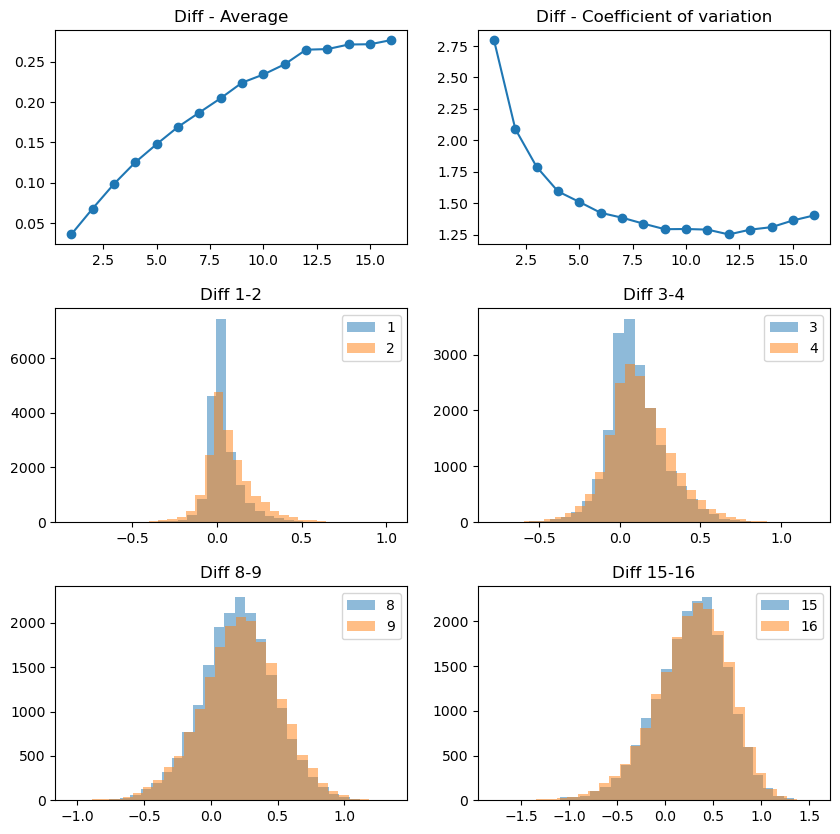

In [76]:
show(groups)